In [1]:
# configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-11_lg-yes"
# configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-bi_mx-1500_lg-no"
# configuration = "fi-100_ft-15000000_nb-30_ht-0_di-uni_mx-1500_lg-no"
configuration = "fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no"
# configuration = "fi-100_ft-15000000_nb-20_ht-100000_di-uni_mx-1500_lg-no"

dataset_path = "datasets"
pre_train_years = [2017, 2018, 2019, 2020]
train_year = 2022
validation_year = 2021
output_dir = "trained_models"

#### Pre-Processing:
seq_length = 128
deduplicate = True
coalesce = True

#### Pre-Training:
do_pre_train = False
pre_train_run_name = "pre_train_all_years_ded_coa_med_seq-128_old_" + configuration
# for largest configuration: use batch size of 48 on A100, 16 on others
# medium configuration: 128 on others
per_device_batch_size = 256
embedding_length = 256
num_attention_heads = 12
num_hidden_layers = 12
num_epochs = 2

#### Fine-Tuning:
do_fine_tune = False
fine_tune_run_name = "fine_tune_all_years_ded_coa_med_seq-128_old_" + configuration
# fine_tune_run_name = "fine_tune_all_years_ded_coa_med_seq-128_abl_" + configuration

num_fine_tune_epochs = 1
fine_tune_per_device_batch_size = 128
fine_tune_per_device_eval_batch_size = 256


#### Evaluation:
do_evaluate = False
use_finetuned_model = True

### Loading Datasets

In [2]:
from data_loader import *
if do_pre_train:
    pre_train_corpus = load_pretrain_data(pre_train_years, configuration, dataset_path)
if do_fine_tune or do_evaluate:
    train_benign_corpus, train_rt_corpus = load_train_data(train_year, configuration, dataset_path)
    valid_benign_corpus, valid_rt_corpus = load_train_data(validation_year, configuration, dataset_path)

Loading data from datasets/yr-2022_fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no.zip


100%|██████████| 44685/44685 [00:10<00:00, 4458.36it/s]


Loading data from datasets/yr-2021_fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no.zip


100%|██████████| 15577/15577 [00:01<00:00, 10790.28it/s]


### Creating Splits

In [3]:
from sklearn.model_selection import train_test_split
if do_pre_train:
    pre_train_train_corpus, pre_train_test_corpus = train_test_split(pre_train_corpus, test_size=0.05, random_state=42)
if do_fine_tune or do_evaluate:
    train_benign_train_corpus, train_benign_test_corpus = train_test_split(train_benign_corpus, test_size=0.1, random_state=42)
    train_rt_train_corpus, train_rt_test_corpus = train_test_split(train_rt_corpus, test_size=0.1, random_state=42)

### Creating Flow-Pair Datasets

In [4]:
from bert_combined_dataset import *
if do_pre_train:
    pre_train_train_data = FlowPairDataset(configuration, pre_train_train_corpus, seq_length=seq_length, deduplicate=deduplicate, coalesce=coalesce, shuffle=True)
    pre_train_test_data = FlowPairDataset(configuration, pre_train_test_corpus, seq_length=seq_length, deduplicate=deduplicate, coalesce=coalesce, shuffle=True)
if do_fine_tune or do_evaluate:
    train_train_data = FlowPairDataset(configuration, train_rt_train_corpus, train_benign_train_corpus, seq_length=seq_length, deduplicate=True, coalesce=coalesce, shuffle=True, balanced=False)
    train_test_data = FlowPairDataset(configuration, train_rt_test_corpus, train_benign_test_corpus, seq_length=seq_length, deduplicate=True, coalesce=coalesce, shuffle=True, balanced=False)
    valid_valid_data = FlowPairDataset(configuration, valid_rt_corpus, valid_benign_corpus, seq_length=seq_length, deduplicate=True, coalesce=coalesce, shuffle=True, balanced=False)


Creating dataset for  fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no
Normalizing corpus 0
Normalizing corpus 1
Coalescing


100%|██████████| 164299/164299 [01:26<00:00, 1894.20it/s]


Creating sentence pairs


100%|██████████| 164299/164299 [00:01<00:00, 112236.37it/s]


Training pairs 0: 967874
Training pairs 1: 5120556
Deduplicating
Training pairs after deduplication (0): 143667
Training pairs after deduplication (1): 1894773
Extracting tokens


0it [00:00, ?it/s]
100%|██████████| 1894773/1894773 [00:17<00:00, 107114.42it/s]


Creating dataset for  fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no
Normalizing corpus 0
Normalizing corpus 1
Coalescing


100%|██████████| 18459/18459 [00:13<00:00, 1402.16it/s]


Creating sentence pairs


100%|██████████| 18459/18459 [00:00<00:00, 28912.65it/s]


Training pairs 0: 70279
Training pairs 1: 2399262
Deduplicating
Training pairs after deduplication (0): 7812
Training pairs after deduplication (1): 147429
Extracting tokens


0it [00:00, ?it/s]
100%|██████████| 147429/147429 [00:01<00:00, 131810.47it/s]


Creating dataset for  fi-100_ft-15000000_nb-30_ht-100000_di-uni_mx-1500_lg-no
Normalizing corpus 0
Normalizing corpus 1
Coalescing


100%|██████████| 8830/8830 [00:15<00:00, 561.12it/s] 


Creating sentence pairs


100%|██████████| 8830/8830 [00:00<00:00, 14060.58it/s]


Training pairs 0: 34050
Training pairs 1: 2367182
Deduplicating
Training pairs after deduplication (0): 12204
Training pairs after deduplication (1): 511880
Extracting tokens


0it [00:00, ?it/s]
100%|██████████| 511880/511880 [00:03<00:00, 147783.04it/s]


### Pre-Training

In [5]:
from pre_train_bert import *
if do_pre_train:
    pretrained_model_path = pre_train_bert(
        run_name=pre_train_run_name,
        config=configuration,
        train_data=pre_train_train_data,
        test_data=pre_train_test_data,
        seq_length=seq_length,
        num_epochs=num_epochs,
        num_hidden_layers= num_hidden_layers,
        num_attention_heads=num_attention_heads,
        embedding_length=embedding_length,
        output_dir=output_dir,
        per_device_train_batch_size=per_device_batch_size,
    )

### Fine-Tuning

In [6]:
from fine_tune_bert import *
if do_fine_tune:
    fine_tune_bert(
        run_name=fine_tune_run_name,
        config=configuration,
        output_dir=output_dir,
        train_data=train_train_data,
        eval_data=valid_valid_data,
        pretrain_run_name=pre_train_run_name,
        per_device_train_batch_size=fine_tune_per_device_batch_size,
        num_epochs=num_fine_tune_epochs,
        per_device_eval_batch_size=fine_tune_per_device_eval_batch_size,
        logging_steps=1,
        save_steps=1,
    )

### Evaluating

In [7]:
from evaluate_bert import *
finetuned_model_path = os.path.join(output_dir, fine_tune_run_name, "finetuned_model")
pretrained_model_path = os.path.join(output_dir, pre_train_run_name, "pretrained_model")
if use_finetuned_model:
    model_path = finetuned_model_path
else:
    model_path = pretrained_model_path
    
# if do_evaluate:
#     train_data, train_labels = get_embeddings(model_path=model_path, data=train_train_data, resample=False)
#     test_data, test_labels = get_embeddings(model_path=model_path, data=train_test_data, resample=False)
#     valid_data, valid_labels = get_embeddings(model_path=model_path, data=valid_valid_data, resample=False)
    
#     train_data_rt = train_data[train_labels == 0]
#     train_data_benign = train_data[train_labels == 1]
#     test_data_rt = test_data[test_labels == 0]
#     test_data_benign = test_data[test_labels == 1]
#     valid_data_rt = valid_data[valid_labels == 0]
#     valid_data_benign = valid_data[valid_labels == 1]

In [8]:
load_path = "dataset_embeddings"
train_data_rt = np.load(load_path + '/' + configuration + '_train_rt.npy')
train_data_benign = np.load(load_path + '/' + configuration + '_train_benign.npy')
test_data_rt = np.load(load_path + '/' + configuration + '_test_rt.npy')
test_data_benign = np.load(load_path + '/' + configuration + '_test_benign.npy')
valid_data_rt = np.load(load_path + '/' + configuration + '_valid_rt.npy')
valid_data_benign = np.load(load_path + '/' + configuration + '_valid_benign.npy')

pre_train_data_rt = np.load(load_path + '/pre_' + configuration + '_train_rt.npy')
pre_train_data_benign = np.load(load_path + '/pre_' + configuration + '_train_benign.npy')
pre_test_data_rt = np.load(load_path + '/pre_' + configuration + '_test_rt.npy')
pre_test_data_benign = np.load(load_path + '/pre_' + configuration + '_test_benign.npy')
pre_valid_data_rt = np.load(load_path + '/pre_' + configuration + '_valid_rt.npy')
pre_valid_data_benign = np.load(load_path + '/pre_' + configuration + '_valid_benign.npy')
print("Loaded embeddings from", load_path)

Loaded embeddings from dataset_embeddings


In [9]:
from evaluate_bert import *
pred_labels, pred_probas, true_labels = infer_label(fine_tuned_model_path=finetuned_model_path, data=valid_valid_data, batch_size=2048, use_labels=True)

100%|██████████| 256/256 [05:01<00:00,  1.18s/it]


In [10]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=["Benign", "RT"]))

              precision    recall  f1-score   support

      Benign       0.24      0.97      0.38     12204
          RT       1.00      0.93      0.96    511880

    accuracy                           0.93    524084
   macro avg       0.62      0.95      0.67    524084
weighted avg       0.98      0.93      0.95    524084



In [27]:
# load_path = "dataset_embeddings"
# train_data_rt = np.load(load_path + '/train_rt.npy')
# train_data_benign = np.load(load_path + '/train_benign.npy')
# test_data_rt = np.load(load_path + '/test_rt.npy')
# test_data_benign = np.load(load_path + '/test_benign.npy')
# valid_data_rt = np.load(load_path + '/valid_rt.npy')
# valid_data_benign = np.load(load_path + '/valid_benign.npy')
# print("Loaded embeddings from", load_path)

Loaded embeddings from dataset_embeddings


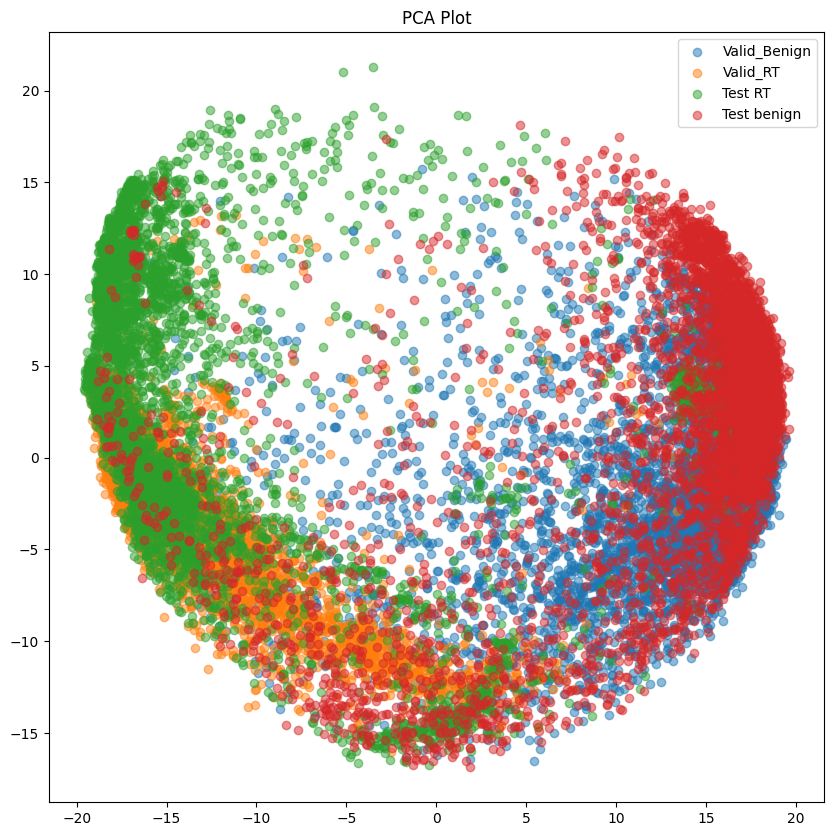

In [12]:
from evaluate_bert import *
visualize_embeddings([valid_data_benign, valid_data_rt, test_data_rt, test_data_benign], ["Valid_Benign", "Valid_RT", "Test RT", "Test benign"], "PCA Plot", "pca", sample=5000)

In [11]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X = np.concatenate([pre_train_data_rt, pre_train_data_benign])
y = np.concatenate([np.zeros(len(pre_train_data_rt)), np.ones(len(pre_train_data_benign))])
X_test = np.concatenate([pre_test_data_rt, pre_test_data_benign])
y_test = np.concatenate([np.zeros(len(pre_test_data_rt)), np.ones(len(pre_test_data_benign))])
X_val = np.concatenate([pre_valid_data_rt, pre_valid_data_benign])
y_val = np.concatenate([np.zeros(len(pre_valid_data_rt)), np.ones(len(pre_valid_data_benign))])

# shuffle all data
# np.random.seed(42)
# idx = np.random.permutation(len(X))
# X = X[idx]
# y = y[idx]
# idx = np.random.permutation(len(X_test))
# X_test = X_test[idx]
# y_test = y_test[idx]
# idx = np.random.permutation(len(X_val))
# X_val = X_val[idx]
# y_val = y_val[idx]

# subsample
# X = X[:100000]
# y = y[:100000]
# X_test = X_test[:100000]
# y_test = y_test[:100000]
# X_val = X_val[:100000]
# y_val = y_val[:100000]

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
clf.fit(X, y)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.52      0.64      7812
         1.0       0.97      0.99      0.98    147429

    accuracy                           0.97    155241
   macro avg       0.91      0.76      0.81    155241
weighted avg       0.97      0.97      0.97    155241

[[  4048   3764]
 [   741 146688]]
Accuracy: 0.9709806043506548
              precision    recall  f1-score   support

         0.0       0.24      0.07      0.11     12204
         1.0       0.98      0.99      0.99    511880

    accuracy                           0.97    524084
   macro avg       0.61      0.53      0.55    524084
weighted avg       0.96      0.97      0.97    524084

[[   880  11324]
 [  2724 509156]]
Accuracy: 0.9731951366574824


In [30]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X = np.concatenate([train_data_rt, train_data_benign])
y = np.concatenate([np.zeros(len(train_data_rt)), np.ones(len(train_data_benign))])
X_test = np.concatenate([test_data_rt, test_data_benign])
y_test = np.concatenate([np.zeros(len(test_data_rt)), np.ones(len(test_data_benign))])
X_val = np.concatenate([valid_data_rt, valid_data_benign])
y_val = np.concatenate([np.zeros(len(valid_data_rt)), np.ones(len(valid_data_benign))])

# shuffle all data
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
idx = np.random.permutation(len(X_test))
X_test = X_test[idx]
y_test = y_test[idx]
idx = np.random.permutation(len(X_val))
X_val = X_val[idx]
y_val = y_val[idx]

# subsample
# X = X[:100000]
# y = y[:100000]
# X_test = X_test[:100000]
# y_test = y_test[:100000]
# X_val = X_val[:100000]
# y_val = y_val[:100000]

clf = LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1).fit(X, y)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74      7812
         1.0       0.99      0.99      0.99    147429

    accuracy                           0.97    155241
   macro avg       0.87      0.86      0.87    155241
weighted avg       0.97      0.97      0.97    155241

[[  5661   2151]
 [  1759 145670]]
Accuracy: 0.9748133547194362
              precision    recall  f1-score   support

         0.0       0.26      0.51      0.34     12204
         1.0       0.99      0.97      0.98    511880

    accuracy                           0.95    524084
   macro avg       0.62      0.74      0.66    524084
weighted avg       0.97      0.95      0.96    524084

[[  6179   6025]
 [ 17826 494054]]
Accuracy: 0.9544901199044428


In [34]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X = np.concatenate([train_data_rt, train_data_benign])
y = np.concatenate([np.zeros(len(train_data_rt)), np.ones(len(train_data_benign))])
X_test = np.concatenate([test_data_rt, test_data_benign])
y_test = np.concatenate([np.zeros(len(test_data_rt)), np.ones(len(test_data_benign))])
X_val = np.concatenate([valid_data_rt, valid_data_benign])
y_val = np.concatenate([np.zeros(len(valid_data_rt)), np.ones(len(valid_data_benign))])

# shuffle all data
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
idx = np.random.permutation(len(X_test))
X_test = X_test[idx]
y_test = y_test[idx]
idx = np.random.permutation(len(X_val))
X_val = X_val[idx]
y_val = y_val[idx]

# subsample
# X = X[:100000]
# y = y[:100000]
# X_test = X_test[:100000]
# y_test = y_test[:100000]
# X_val = X_val[:100000]
# y_val = y_val[:100000]

clf = SVC(kernel='linear', C=0.00001)
clf.fit(X, y)

print("Finished training")

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report

# Concatenate features and create labels
X = np.concatenate([test_data_rt[:50000], test_data_benign[:50000]], axis=0)  # Concatenate feature arrays
y = np.concatenate([np.zeros(len(test_data_rt[:50000])), np.ones(len(test_data_benign[:50000]))])  # Create labels

# Initialize and fit the nearest neighbor classifier
k = 5  # Number of neighbors to consider
nn_classifier = KNeighborsClassifier(n_neighbors=k, metric='cosine')
nn_classifier.fit(X, y)

print("Data fitted")

# save model
import pickle
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(nn_classifier, f)

X_test = np.concatenate([valid_data_rt, valid_data_benign], axis=0)  # Concatenate feature arrays
y_test = np.concatenate([np.zeros(len(valid_data_rt)), np.ones(len(valid_data_benign))])  # Create labels

# Predict the labels of the test data
predicted_labels = nn_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, predicted_labels, target_names=["RT", "Benign"]))

# X_valid = np.concatenate([valid_data_rt, valid_data_benign], axis=0)  # Concatenate feature arrays
# y_valid = np.concatenate([np.zeros(len(valid_data_rt)), np.ones(len(valid_data_benign))])  # Create labels

# # Predict the labels of the test data
# predicted_labels_valid = nn_classifier.predict(X_valid)

# # Print the classification report
# print(classification_report(y_valid, predicted_labels_valid, target_names=["RT", "Benign"]))

Data fitted
              precision    recall  f1-score   support

          RT       0.41      0.65      0.50     12182
      Benign       0.99      0.98      0.98    457219

    accuracy                           0.97    469401
   macro avg       0.70      0.81      0.74    469401
weighted avg       0.98      0.97      0.97    469401



In [ ]:
from evaluate_bert import *
evaluate_classifier(train_data_rt, train_data_benign, valid_data_rt, valid_data_benign, classifier="SVM", threshold=0.01, hyperparameters={"C": 0.001, "kernel": "linear"})

In [ ]:
from sklearn.svm import SVC

threshold = 0.01

clf = SVC(C=0.000000001,kernel='linear', probability=True)
    
X_train = np.concatenate([train_data_rt, train_data_benign])
y_train = np.concatenate([np.zeros(len(train_data_rt)), np.ones(len(train_data_benign))])
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

X_test = np.concatenate([valid_data_rt, valid_data_benign])
y_test = np.concatenate([np.zeros(len(valid_data_rt)), np.ones(len(valid_data_benign))])

clf.fit(X_train, y_train)

# save model to file
import joblib
joblib.dump(clf, "svm_model.pkl")

y_proba = clf.predict_proba(X_test)[:,1]
y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))

fpr = np.sum((y_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)
print("False Positive Rate:", fpr)